In [1]:
import os
import sys
import argparse

from astropy.table import Table, join
from datasets import load_dataset
import h5py
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from math import pi
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.helpers import zero_shot_train, few_shot_train, plot_radar, resnet_r2, photometry_r2, spender_r2
from utils.models import SimpleMLP

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

# Overall Definitions:
properties = ['Z_HP']
property_titles = ['$Z_{HP}$']
scaler = StandardScaler()

prop_dict = {
    'Z_HP': {
        'xlabel': 'True Redshift',
        'ylabel': 'Predicted Redshift',
        'lim_range': (0, 0.65),
        'text_position': (0.05, 0.55)
    }
}

# ----- Replace with new Dataset Loader ----- #
def get_provabgs(embedding_file, images=True):
    
    # Retrieve your CLIP embeddings
    CLIP_embeddings = h5py.File(embedding_file, 'r') 
    train_embeddings = CLIP_embeddings['train']
    test_embeddings  = CLIP_embeddings['test']
    
    if images:
        train_table = Table({'targetid': train_embeddings['targetid'], 
                             'image_features': train_embeddings['image_features']})

        test_table  = Table({'targetid': test_embeddings['targetid'], 
                             'image_features': test_embeddings['image_features']})
    
    else:
        train_table = Table({'targetid': train_embeddings['targetid'], 
                             'spectra_features': train_embeddings['spectra_features']})

        test_table  = Table({'targetid': test_embeddings['targetid'], 
                             'spectra_features': test_embeddings['spectra_features']})
        
    provabgs = Table.read('/mnt/home/lparker/ceph/BGS_ANY_full.provabgs.sv3.v0.hdf5')
    provabgs = provabgs[(provabgs['LOG_MSTAR'] > 0) * (provabgs['MAG_G'] > 0) * (provabgs['MAG_R'] > 0) * (provabgs['MAG_Z'] > 0)]
    inds = np.random.permutation(len(provabgs))
    provabgs = provabgs[inds]

    train_provabgs = join(provabgs, train_table, keys_left='TARGETID', keys_right='targetid')
    test_provabgs  = join(provabgs, test_table, keys_left='TARGETID', keys_right='targetid')
    
    return train_provabgs, test_provabgs
# -------------------------------------------- #

def get_data(embedding_file, images=True):
    train_provabgs, test_provabgs = get_provabgs(embedding_file, images)
    
    # Scale the galaxy property data
    prop_scalers = {}
    y_train, y_test = torch.zeros((len(train_provabgs), len(properties))), torch.zeros((len(test_provabgs), len(properties)))
    for i, p in enumerate(properties):
        prop_train, prop_test = train_provabgs[p].reshape(-1, 1), test_provabgs[p].reshape(-1, 1)
        if p == 'Z_MW': 
            prop_train, prop_test = np.log(prop_train), np.log(prop_test)
        if p == 'SFR': 
            prop_train, prop_test = np.log(prop_train)-train_provabgs['LOG_MSTAR'].reshape(-1, 1), np.log(prop_test)-test_provabgs['LOG_MSTAR'].reshape(-1, 1)
        
        prop_scaler = StandardScaler().fit(prop_train)    
        prop_train, prop_test = prop_scaler.transform(prop_train), prop_scaler.transform(prop_test)
        y_train[:, i], y_test[:, i] = torch.tensor(prop_train.squeeze(), dtype=torch.float32), torch.tensor(prop_test.squeeze(), dtype=torch.float32)
        prop_scalers[p] = prop_scaler
    
    if images:
        train_images, test_images = train_provabgs['image_features'], test_provabgs['image_features']
        image_scaler = StandardScaler().fit(train_images)
        train_images, test_images = image_scaler.transform(train_images), image_scaler.transform(test_images)
    
        data = {'X_train': train_images,
                'X_test': test_images,
                'y_train': y_train,
                'y_test': y_test}
        
    else:
        train_spectra, test_spectra = train_provabgs['spectra_features'], test_provabgs['spectra_features']
        spectrum_scaler = StandardScaler().fit(train_spectra)
        train_spectra, test_spectra = spectrum_scaler.transform(train_spectra), spectrum_scaler.transform(test_spectra)
        
        data = {'X_train': train_spectra,
                'X_test': test_spectra,
                'y_train': y_train,
                'y_test': y_test}
    
    return data, prop_scalers


/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/sw/nix/store/7bjp92vyxq4vmcm6q2kwdv325d50n362-py-torchvision-0.14.1/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_hidden=1):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for i in range(n_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(self.n_hidden+1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

def few_shot_train(X_train, y_train, X_test, y_test, properties, r2_only=True):
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = MLP(X_train.shape[1], y_train.shape[1], hidden_dim=32, n_hidden=0)
    model.cuda()
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs.cuda()).detach().cpu()
            preds.append(outputs)
            trues.append(labels)
    
    preds = torch.cat(preds, dim=0).numpy()
    return preds

In [3]:
source = 'images'
embedding_file = '/mnt/home/lparker/ceph/good_embeddings/newest_embeddings_new.h5py'
stein_embedding_file='/mnt/home/lparker/ceph/stein_propertyembeddings.h5'
DINO_embedding_file='/mnt/home/lparker/ceph/DINO_embeddings.h5'
GalFormer_embedding_file='/mnt/home/lparker/ceph/GalFormer_embeddings.h5'
train_type = 'zero_shot'
save_dir = 'redshift'

images = True if source == 'images' else False

data = {}
data['clip'], scaler = get_data(embedding_file, images=images)
data['DINO'], _ = get_data(DINO_embedding_file, images=images)
data['stein'], _ = get_data(stein_embedding_file, images=images)
baseline_type = 'ResNet18'

scaler = scaler['Z_HP']

preds, truths = {}, {}

In [4]:
# SSL Models
for key in data.keys():
    preds[key] = zero_shot_train(data[key]['X_train'], data[key]['y_train'], data[key]['X_test'], data[key]['y_test'], properties, r2_only=False)
    truths[key] = scaler.inverse_transform(data[key]['y_test'].reshape(-1,1)).squeeze()
    preds[key] = scaler.inverse_transform(preds[key].reshape(-1,1)).squeeze()

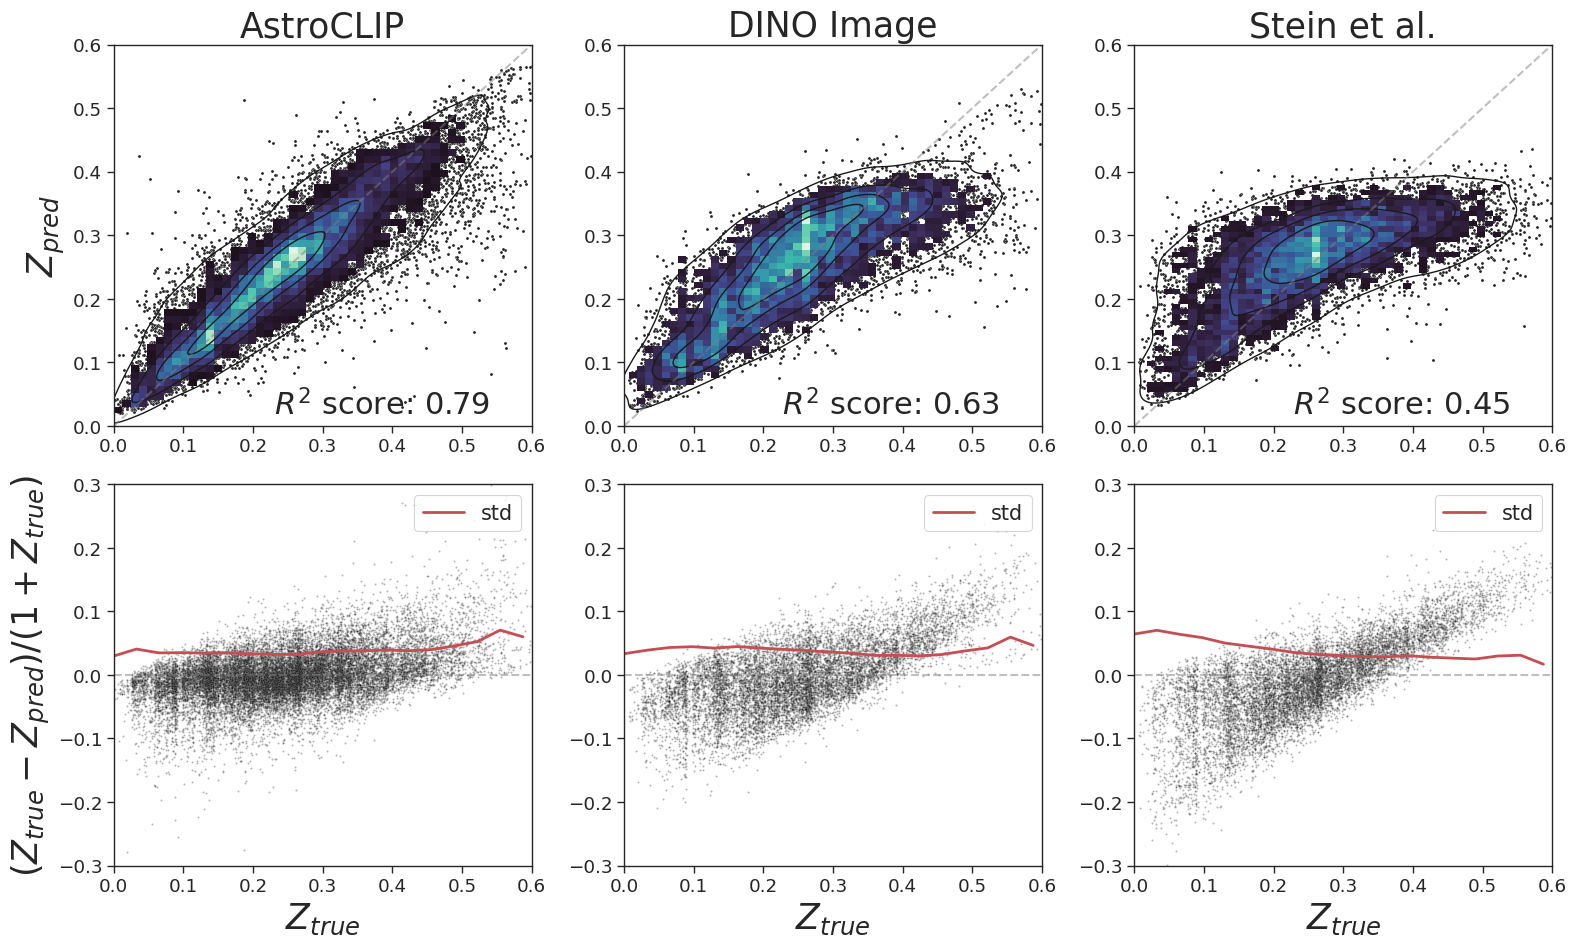

In [13]:
fig, ax = plt.subplots(2, len(preds.keys()), figsize=(16, 10))

names = ['AstroCLIP', 'DINO Image', 'Stein et al.', 'ResNet18', 'Photometry']

for i, name in enumerate(preds.keys()):
    config = prop_dict['Z_HP']

    sns.scatterplot(ax=ax[0,i], x=truths[name], y=preds[name], s=5, color='.15')
    sns.histplot(ax=ax[0,i], x=truths[name], y=preds[name], bins=50, pthresh=.1, cmap='mako')
    sns.kdeplot(ax=ax[0,i], x=truths[name], y=preds[name], levels=5, color='k', linewidths=1)

    ax[0,i].plot(config['lim_range'], config['lim_range'], '--', linewidth=1.5, alpha=0.5, color='grey')
    ax[0,i].set_xlim(0, 0.6)
    ax[0,i].set_ylim(0, 0.6)
    ax[0,i].text(0.9, 0.1, '$R^2$ score: %0.2f' % r2_score(truths[name], preds[name]), horizontalalignment='right', verticalalignment='top', fontsize=22, transform=ax[0,i].transAxes)
    ax[0,i].set_title(names[i], fontsize=25)

ax[0,0].set_ylabel('$Z_{pred}$', fontsize=25)

for i, name in enumerate(preds.keys()):
    x = truths[name]
    y = (truths[name]-preds[name])/(1+truths[name])

    bins = np.linspace(0, 0.62, 20)
    x_binned = np.digitize(x, bins)
    y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
    y_std = [y[x_binned == i].std() for i in range(1, len(bins))]

    sns.scatterplot(ax=ax[1,i], x=x, y=y, s=2, alpha=0.3, color='black')
    sns.lineplot(ax=ax[1,i], x=bins[:-1], y=y_std, color='r', label='std')

    # horizontal line on y = 0
    ax[1,i].axhline(0, color='grey', linewidth=1.5, alpha=0.5, linestyle='--')

    #sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
    ax[1,i].set_xlim(0, 0.6)
    ax[1,i].set_ylim(-0.3, 0.3)
    ax[1,i].set_xlabel('$Z_{true}$', fontsize=25)
    ax[1,i].legend(fontsize=15, loc='upper right')

ax[1,0].set_ylabel('$(Z_{true}-Z_{pred})/(1+Z_{true})$', fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'redshift_comparison_zero_shot.png', dpi=300)

In [14]:
preds, truths = {}, {}

for key in data.keys():
    preds[key] = few_shot_train(data[key]['X_train'], data[key]['y_train'], data[key]['X_test'], data[key]['y_test'], properties, r2_only=False)
    truths[key] = scaler.inverse_transform(data[key]['y_test'].reshape(-1,1)).squeeze()
    preds[key] = scaler.inverse_transform(preds[key].reshape(-1,1)).squeeze()

/tmp/ipykernel_3665929/3847415591.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_3665929/3847415591.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_3665929/3847415591.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_3665929/3847415591.py:22: UserWarning: To c

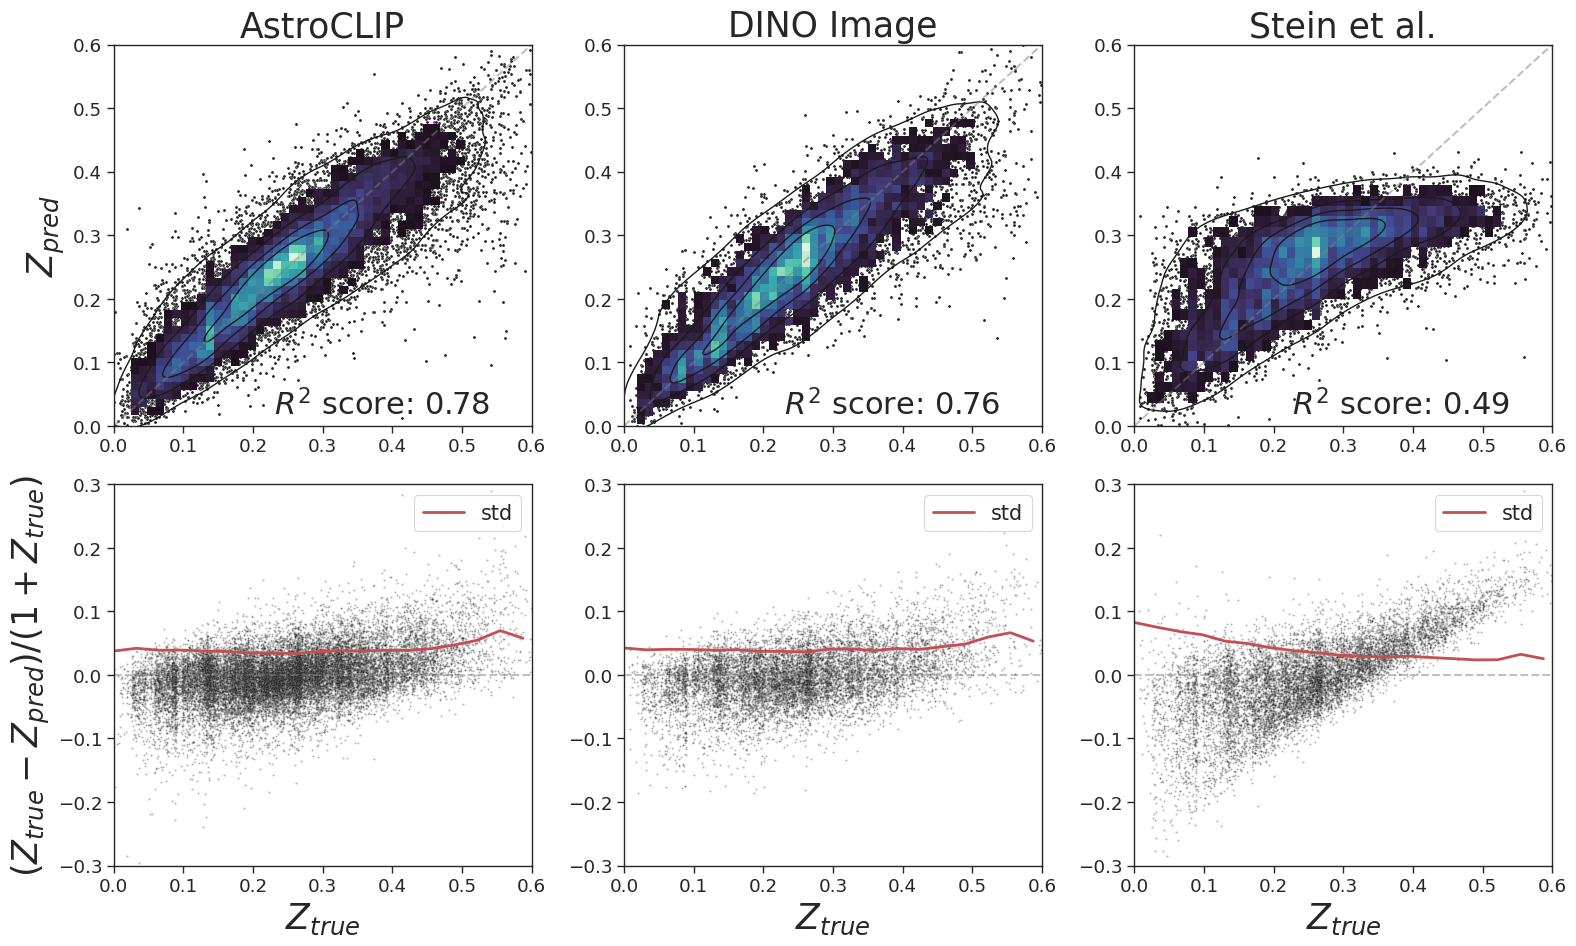

In [15]:
fig, ax = plt.subplots(2, len(preds.keys()), figsize=(16, 10))

names = ['AstroCLIP', 'DINO Image', 'Stein et al.', 'ResNet18', 'Photometry']

for i, name in enumerate(preds.keys()):
    config = prop_dict['Z_HP']

    sns.scatterplot(ax=ax[0,i], x=truths[name], y=preds[name], s=5, color='.15')
    sns.histplot(ax=ax[0,i], x=truths[name], y=preds[name], bins=50, pthresh=.1, cmap='mako')
    sns.kdeplot(ax=ax[0,i], x=truths[name], y=preds[name], levels=5, color='k', linewidths=1)

    ax[0,i].plot(config['lim_range'], config['lim_range'], '--', linewidth=1.5, alpha=0.5, color='grey')
    ax[0,i].set_xlim(0, 0.6)
    ax[0,i].set_ylim(0, 0.6)
    ax[0,i].text(0.9, 0.1, '$R^2$ score: %0.2f' % r2_score(truths[name], preds[name]), horizontalalignment='right', verticalalignment='top', fontsize=22, transform=ax[0,i].transAxes)
    ax[0,i].set_title(names[i], fontsize=25)

ax[0,0].set_ylabel('$Z_{pred}$', fontsize=25)

for i, name in enumerate(preds.keys()):
    x = truths[name]
    y = (truths[name]-preds[name])/(1+truths[name])

    bins = np.linspace(0, 0.62, 20)
    x_binned = np.digitize(x, bins)
    y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
    y_std = [y[x_binned == i].std() for i in range(1, len(bins))]

    sns.scatterplot(ax=ax[1,i], x=x, y=y, s=2, alpha=0.3, color='black')
    sns.lineplot(ax=ax[1,i], x=bins[:-1], y=y_std, color='r', label='std')

    # horizontal line on y = 0
    ax[1,i].axhline(0, color='grey', linewidth=1.5, alpha=0.5, linestyle='--')

    #sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
    ax[1,i].set_xlim(0, 0.6)
    ax[1,i].set_ylim(-0.3, 0.3)
    ax[1,i].set_xlabel('$Z_{true}$', fontsize=25)
    ax[1,i].legend(fontsize=15, loc='upper right')

ax[1,0].set_ylabel('$(Z_{true}-Z_{pred})/(1+Z_{true})$', fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'redshift_comparison_few_shot.png', dpi=300)

In [20]:
preds, truths = {}, {}

# ResNet18 Baseline
baseline = torch.load('baseline_models/resnet_results')
preds[baseline_type] = scaler.inverse_transform(baseline['test_preds'][:,0].reshape(-1,1)).squeeze()
truths[baseline_type] = scaler.inverse_transform(baseline['test_trues'][:,0].reshape(-1,1)).squeeze()

# Photometry Baseline
baseline = torch.load('baseline_models/photometry_baseline_new')
preds['Photometry'] = scaler.inverse_transform(baseline['test_preds'][:,0].reshape(-1,1)).squeeze()
truths['Photometry'] = scaler.inverse_transform(baseline['test_trues'][:,0].reshape(-1,1)).squeeze()

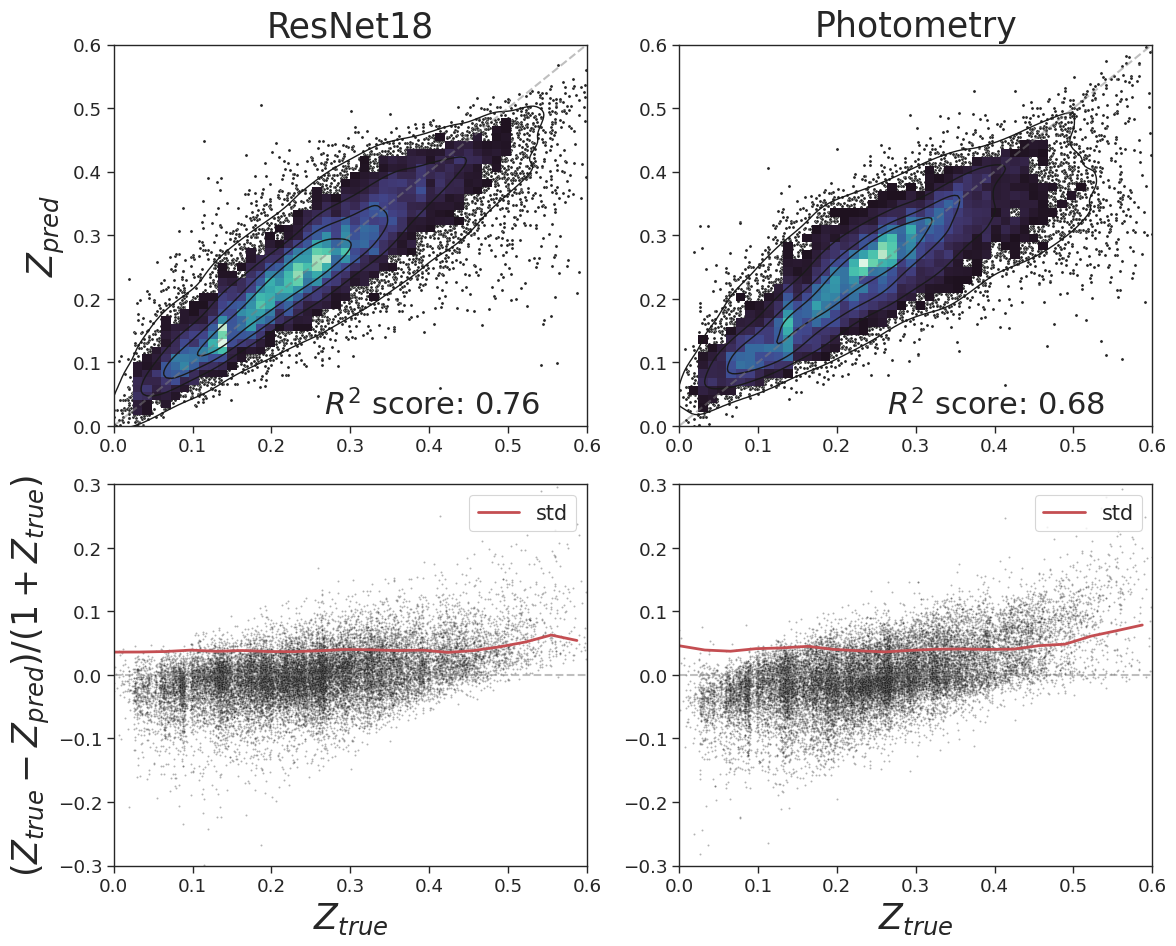

In [21]:
fig, ax = plt.subplots(2, len(preds.keys()), figsize=(12, 10))

names = ['ResNet18', 'Photometry']

for i, name in enumerate(preds.keys()):
    config = prop_dict['Z_HP']

    sns.scatterplot(ax=ax[0,i], x=truths[name], y=preds[name], s=5, color='.15')
    sns.histplot(ax=ax[0,i], x=truths[name], y=preds[name], bins=50, pthresh=.1, cmap='mako')
    sns.kdeplot(ax=ax[0,i], x=truths[name], y=preds[name], levels=5, color='k', linewidths=1)

    ax[0,i].plot(config['lim_range'], config['lim_range'], '--', linewidth=1.5, alpha=0.5, color='grey')
    ax[0,i].set_xlim(0, 0.6)
    ax[0,i].set_ylim(0, 0.6)
    ax[0,i].text(0.9, 0.1, '$R^2$ score: %0.2f' % r2_score(truths[name], preds[name]), horizontalalignment='right', verticalalignment='top', fontsize=22, transform=ax[0,i].transAxes)
    ax[0,i].set_title(names[i], fontsize=25)

ax[0,0].set_ylabel('$Z_{pred}$', fontsize=25)

for i, name in enumerate(preds.keys()):
    x = truths[name]
    y = (truths[name]-preds[name])/(1+truths[name])

    bins = np.linspace(0, 0.62, 20)
    x_binned = np.digitize(x, bins)
    y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
    y_std = [y[x_binned == i].std() for i in range(1, len(bins))]

    sns.scatterplot(ax=ax[1,i], x=x, y=y, s=2, alpha=0.3, color='black')
    sns.lineplot(ax=ax[1,i], x=bins[:-1], y=y_std, color='r', label='std')

    # horizontal line on y = 0
    ax[1,i].axhline(0, color='grey', linewidth=1.5, alpha=0.5, linestyle='--')

    #sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
    ax[1,i].set_xlim(0, 0.6)
    ax[1,i].set_ylim(-0.3, 0.3)
    ax[1,i].set_xlabel('$Z_{true}$', fontsize=25)
    ax[1,i].legend(fontsize=15, loc='upper right')

ax[1,0].set_ylabel('$(Z_{true}-Z_{pred})/(1+Z_{true})$', fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'redshift_supervised.png', dpi=300)

In [22]:
source = 'spectra'
embedding_file = '/mnt/home/lparker/ceph/good_embeddings/newest_embeddings_new.h5py'
stein_embedding_file='/mnt/home/lparker/ceph/stein_propertyembeddings.h5'
DINO_embedding_file='/mnt/home/lparker/ceph/DINO_embeddings.h5'
GalFormer_embedding_file='/mnt/home/lparker/ceph/GalFormer_embeddings.h5'
train_type = 'zero_shot'
save_dir = 'redshift'

images = True if source == 'images' else False

data = {}
data['clip'], scaler = get_data(embedding_file, images=images)
data['galformer'], scaler = get_data(GalFormer_embedding_file, images=images)

scaler = scaler['Z_HP']

preds, truths = {}, {}

In [23]:
for key in data.keys():
    preds[key] = zero_shot_train(data[key]['X_train'], data[key]['y_train'], data[key]['X_test'], data[key]['y_test'], properties, r2_only=False)
    truths[key] = scaler.inverse_transform(data[key]['y_test'].reshape(-1,1)).squeeze()
    preds[key] = scaler.inverse_transform(preds[key].reshape(-1,1)).squeeze()

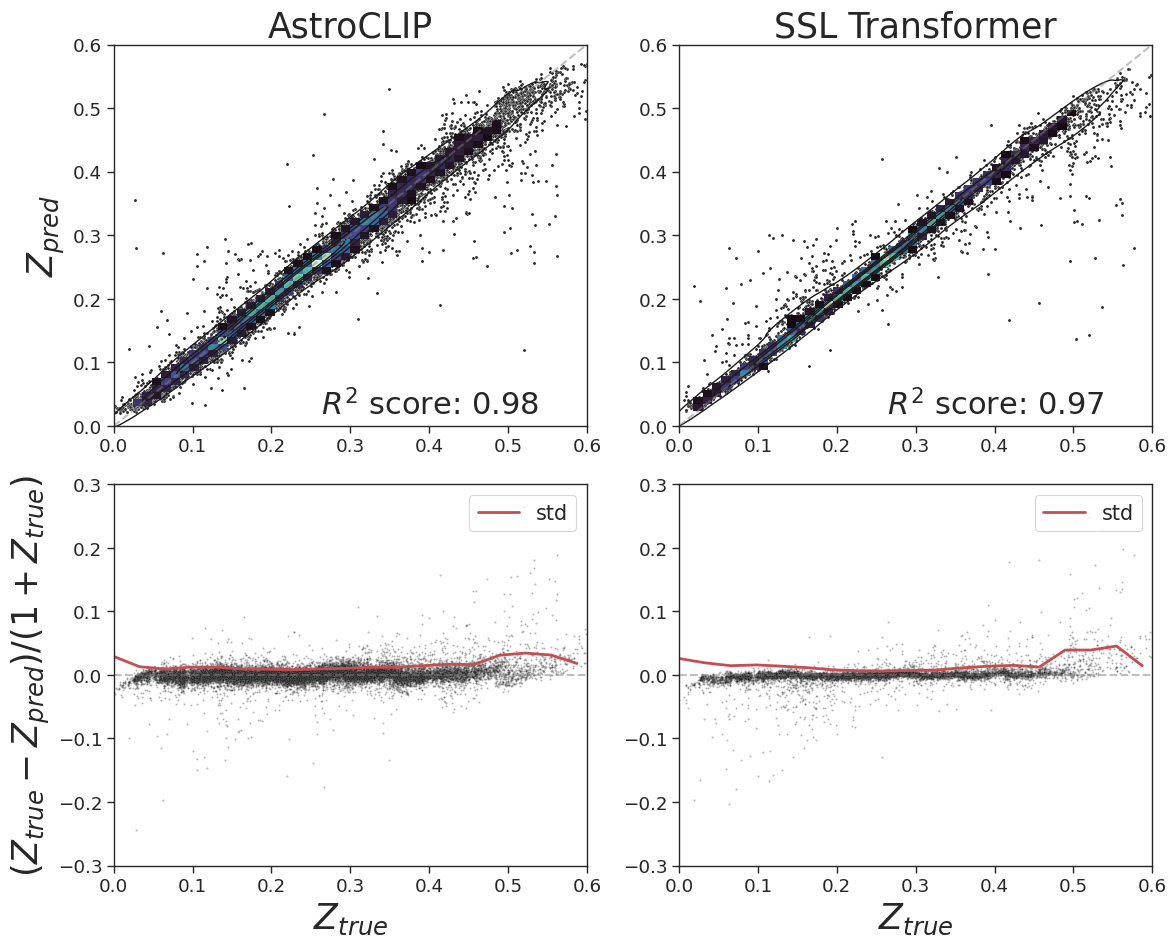

In [24]:
fig, ax = plt.subplots(2, len(preds.keys()), figsize=(12, 10))

names = ['AstroCLIP', 'SSL Transformer']

for i, name in enumerate(preds.keys()):
    config = prop_dict['Z_HP']

    sns.scatterplot(ax=ax[0,i], x=truths[name], y=preds[name], s=5, color='.15')
    sns.histplot(ax=ax[0,i], x=truths[name], y=preds[name], bins=50, pthresh=.1, cmap='mako')
    sns.kdeplot(ax=ax[0,i], x=truths[name], y=preds[name], levels=5, color='k', linewidths=1)

    ax[0,i].plot(config['lim_range'], config['lim_range'], '--', linewidth=1.5, alpha=0.5, color='grey')
    ax[0,i].set_xlim(0, 0.6)
    ax[0,i].set_ylim(0, 0.6)
    ax[0,i].text(0.9, 0.1, '$R^2$ score: %0.2f' % r2_score(truths[name], preds[name]), horizontalalignment='right', verticalalignment='top', fontsize=22, transform=ax[0,i].transAxes)
    ax[0,i].set_title(names[i], fontsize=25)

ax[0,0].set_ylabel('$Z_{pred}$', fontsize=25)

for i, name in enumerate(preds.keys()):
    x = truths[name]
    y = (truths[name]-preds[name])/(1+truths[name])

    bins = np.linspace(0, 0.62, 20)
    x_binned = np.digitize(x, bins)
    y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
    y_std = [y[x_binned == i].std() for i in range(1, len(bins))]

    sns.scatterplot(ax=ax[1,i], x=x, y=y, s=2, alpha=0.3, color='black')
    sns.lineplot(ax=ax[1,i], x=bins[:-1], y=y_std, color='r', label='std')

    # horizontal line on y = 0
    ax[1,i].axhline(0, color='grey', linewidth=1.5, alpha=0.5, linestyle='--')

    #sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
    ax[1,i].set_xlim(0, 0.6)
    ax[1,i].set_ylim(-0.3, 0.3)
    ax[1,i].set_xlabel('$Z_{true}$', fontsize=25)
    ax[1,i].legend(fontsize=15, loc='upper right')

ax[1,0].set_ylabel('$(Z_{true}-Z_{pred})/(1+Z_{true})$', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'spectrum_zero_shot.png', dpi=300)

In [21]:
for key in data.keys():
    preds[key] = few_shot_train(data[key]['X_train'], data[key]['y_train'], data[key]['X_test'], data[key]['y_test'], properties, r2_only=False)
    truths[key] = scaler.inverse_transform(data[key]['y_test'].reshape(-1,1)).squeeze()
    preds[key] = scaler.inverse_transform(preds[key].reshape(-1,1)).squeeze()

/tmp/ipykernel_3532901/3847415591.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_3532901/3847415591.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_3532901/3847415591.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_3532901/3847415591.py:22: UserWarning: To c

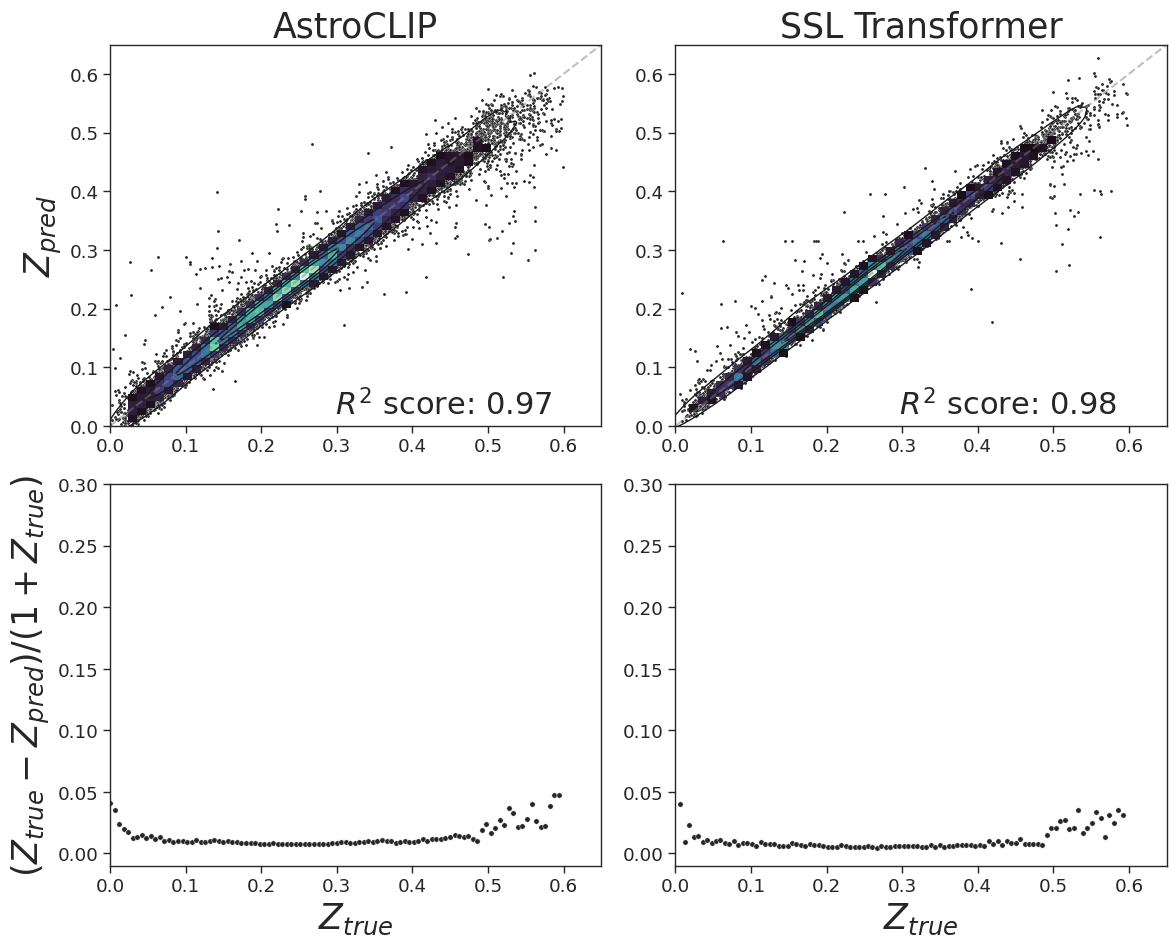

In [22]:
fig, ax = plt.subplots(2, len(preds.keys()), figsize=(12, 10))

names = ['AstroCLIP', 'SSL Transformer']

for i, name in enumerate(preds.keys()):
    config = prop_dict['Z_HP']

    sns.scatterplot(ax=ax[0,i], x=truths[name], y=preds[name], s=5, color='.15')
    sns.histplot(ax=ax[0,i], x=truths[name], y=preds[name], bins=50, pthresh=.1, cmap='mako')
    sns.kdeplot(ax=ax[0,i], x=truths[name], y=preds[name], levels=5, color='k', linewidths=1)

    ax[0,i].plot(config['lim_range'], config['lim_range'], '--', linewidth=1.5, alpha=0.5, color='grey')
    ax[0,i].set_xlim(*config['lim_range'])
    ax[0,i].set_ylim(*config['lim_range'])
    ax[0,i].text(0.9, 0.1, '$R^2$ score: %0.2f' % r2_score(truths[name], preds[name]), horizontalalignment='right', verticalalignment='top', fontsize=22, transform=ax[0,i].transAxes)
    ax[0,i].set_title(names[i], fontsize=25)


ax[0,0].set_ylabel('$Z_{pred}$', fontsize=25)

for i, name in enumerate(preds.keys()):
    x = truths[name]
    y = abs(truths[name]-preds[name])/(1+truths[name])

    bins = np.linspace(x.min(), x.max(), 101)
    x_binned = np.digitize(x, bins)
    y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]

    sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
    ax[1,i].set_xlim(0, 0.65)
    ax[1,i].set_ylim(-0.01, 0.3)
    ax[1,i].set_xlabel('$Z_{true}$', fontsize=25)

ax[1,0].set_ylabel('$(Z_{true}-Z_{pred})/(1+Z_{true})$', fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f'spectrum_few_shot.png', dpi=300)